## TensorFlow2教程-Eager Execution

TensorFlow 的 Eager Execution 是一种命令式编程环境，可立即评估操作，无需构建图：操作会返回具体的值，而不是构建以后再运行的计算图。这样可以轻松地使用 TensorFlow 和调试模型，并且还减少了样板代码。

Eager Execution 是一个灵活的机器学习平台，用于研究和实验，可提供：

- 直观的界面 - 自然地组织代码结构并使用 Python 数据结构。快速迭代小模型和小型数据集。
- 更轻松的调试功能 - 直接调用操作以检查正在运行的模型并测试更改。使用标准 Python 调试工具进行即时错误报告。
- 自然控制流程 - 使用 Python 控制流程而不是图控制流程，简化了动态模型的规范。

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
print(tf.__version__)
# 在tensorflow2中默认使用Eager Execution
tf.executing_eagerly()

2.8.0


True

### 1.Eager Execution下运算
在Eager Execution下可以直接进行运算，结果会立即返回

In [2]:
x = [[3.]]
m = tf.matmul(x, x)
m

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.]], dtype=float32)>

启用Eager Execution会改变TensorFlow操作的行为 - 现在他们会立即评估并将其值返回给Python。tf.Tensor对象引用具体值，而不再是指向计算图中节点的符号句柄。由于在会话中没有构建和运行的计算图，因此使用print()或调试程序很容易检查结果。评估，打印和检查张量值不会破坏计算梯度的流程。

Eager Execution可以与NumPy很好地协作。NumPy操作接受tf.Tensor参数。TensorFlow 数学运算将Python对象和NumPy数组转换为tf.Tensor对象。tf.Tensor.numpy方法将对象的值作为NumPy的ndarray类型返回。

In [4]:
# tf.Tensor对象引用具体值
a = tf.constant([[1,9],[3,6]])
print(a)

# 支持broadcast广播操作
b = tf.add(a, 2)
print(b)

# 支持运算符重载
print(a*b)

# 可以当做numpy数据使用
import numpy as np
s = np.multiply(a,b)
print(s)

# 转换为numpy类型
print(a.numpy())

tf.Tensor(
[[1 9]
 [3 6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 3 11]
 [ 5  8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 3 99]
 [15 48]], shape=(2, 2), dtype=int32)
[[ 3 99]
 [15 48]]
[[1 9]
 [3 6]]


### 2.动态控制流
Eager Execution的一个主要好处是在执行模型时可以使用宿主语言(Python)的所有功能。所以，例如，写fizzbuzz很容易：

In [5]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    # 使用range遍历
    for num in range(1, max_num.numpy()+1):
        # 重新转为tensor类型
        num = tf.constant(num)
        # 使用if-elif 做判断
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1  # 自加运算
fizzbuzz(16)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16


### 3.在Eager Execution下训练
### 计算梯度
自动微分对于实现机器学习算法（例如用于训练神经网络的反向传播）来说是很有用的。在 Eager Execution中，使用 tf.GradientTape 来跟踪操作以便稍后计算梯度。

可以用tf.GradientTape来训练和/或计算梯度。它对复杂的训练循环特别有用。

由于在每次调用期间可能发生不同的操作，所有前向传递操作都被记录到“磁带”中。要计算梯度，请向反向播放磁带，然后丢弃。特定的tf.GradientTape只能计算一个梯度; 后续调用会引发运行时错误。

In [7]:
w = tf.Variable([[1.0]])
# 用tf.GradientTape()记录梯度
with tf.GradientTape() as tape:
    loss = w*w*w
grad = tape.gradient(loss, w)  # 计算梯度
print(grad)

tf.Tensor([[3.]], shape=(1, 1), dtype=float32)


Logits:  [[-0.04839642  0.01856184 -0.01641415 -0.00544873 -0.02372236  0.00215649
   0.00704075  0.01947484  0.00014956  0.01492135]]
........................................

Text(0, 0.5, 'Loss [entropy]')

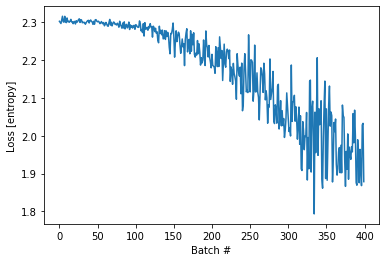

In [8]:
# 训练模型
# 导入mnist数据
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()
# 数据转换
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
# 数据打乱与分批次
dataset = dataset.shuffle(1000).batch(32)
# 使用Sequential构建一个卷积网络
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu', 
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
# 展示数据
# 即使没有经过培训，也可以调用模型并在Eager Execution中检查输出
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())
    
# 优化器与损失函数
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 按批次训练
# 虽然 keras 模型具有内置训练循环（fit 方法），但有时需要更多自定义设置。下面是一个用 eager 实现的训练循环示例：
loss_history = []
for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    with tf.GradientTape() as tape:
        # 获取预测结果
        logits = mnist_model(images, training=True)
        # 获取损失
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    # 获取本批数据梯度
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    # 反向传播优化
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    
# 绘图展示loss变化
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### 4.变量求导优化
tf.Variable对象存储在训练期间访问的可变tf.Tensor值，以使自动微分更容易。模型的参数可以作为变量封装在类中。

将tf.Variable 和tf.GradientTape 结合，可以更好地封装模型参数。例如，可以重写上面的自动微分示例为：

In [9]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

# 满足函数3 * x + 2的数据
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 损失函数
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

# 梯度函数
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

# 模型与优化器
model = MyModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 训练循环，反向传播优化
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.016
Loss at step 000: 65.370
Loss at step 020: 29.763
Loss at step 040: 13.843
Loss at step 060: 6.725
Loss at step 080: 3.541
Loss at step 100: 2.117
Loss at step 120: 1.480
Loss at step 140: 1.195
Loss at step 160: 1.068
Loss at step 180: 1.011
Loss at step 200: 0.985
Loss at step 220: 0.974
Loss at step 240: 0.968
Loss at step 260: 0.966
Loss at step 280: 0.965
Final loss: 0.965
W = 3.0082600116729736, B = 2.060518980026245


### 5.Eager Execution中的对象
使用 Graph Execution 时，程序状态（如变量）存储在全局集合中，它们的生命周期由 tf.Session 对象管理。相反，在 Eager Execution 期间，状态对象的生命周期由其对应的 Python 对象的生命周期决定。

### 变量对象
变量将持续存在，直到删除对象的最后一个引用，然后变量被删除。

In [10]:
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random.normal([1000, 1000]))
        v = None  # v no longer takes up GPU memory

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


### 基于对象的保存
tf.train.Checkpoint 可以将 tf.Variable 保存到检查点并从中恢复：

In [11]:
# 使用检测点保存变量
x = tf.Variable(6.0)
checkpoint = tf.train.Checkpoint(x=x)
# 变量的改变会同步到检测点
x.assign(1.0)
checkpoint.save('./ckpt/')
# 检测点保存后，变量的改变对检测点无影响
x.assign(8.0)
checkpoint.restore(tf.train.latest_checkpoint('./ckpt/'))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


要保存和加载模型，tf.train.Checkpoint 会存储对象的内部状态，而不需要隐藏变量。要记录 model、optimizer 和全局步的状态，可以将它们传递到 tf.train.Checkpoint：

In [12]:
# 模型保持
import os
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = './ck_model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# 将优化器和模型记录至检测点
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)
# 保存检测点
root.save(checkpoint_prefix)
# 读取检测点
root.restore(tf.train.latest_checkpoint(checkpoint_dir))               

### 面向对象的指标
tf.keras.metrics存储为对象。通过将新数据传递给callable来更新度量标准，并使用tf.keras.metrics.result方法检索结果，例如：

In [15]:
m = tf.keras.metrics.Mean('loss')
m(0)
m(5)
print(m.result())  # => 2.5
m([8, 9])
print(m.result())  # => 5.5

tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float32)


### 6.自动微分高级内容
### 动态模型
tf.GradientTape 也可用于动态模型。这个回溯线搜索算法示例看起来像普通的 NumPy 代码，除了存在梯度并且可微分，尽管控制流比较复杂：

In [16]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # 变量会自动记录，但需要手动观察张量
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

### 自定义梯度
自定义梯度是在 Eager Execution 和 Graph Execution 中覆盖梯度的一种简单方式。在正向函数中，定义相对于输入、输出或中间结果的梯度。例如，下面是在反向传播中截断梯度范数的一种简单方式：

In [18]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [19]:
# 自定义梯度可以提供数值稳定的梯度
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)
# 梯度计算在x = 0时工作正常。
print(grad_log1pexp(tf.constant(0.)).numpy())
# 但是，由于数值不稳定，x = 100失败。
print(grad_log1pexp(tf.constant(100.)).numpy())

0.5
nan


这里，log1pexp函数可以使用自定义梯度求导进行分析简化。 下面的实现重用了在前向传递期间计算的tf.exp（x）的值 - 通过消除冗余计算使其更有效：

In [20]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)
# 和以前一样，梯度计算在x = 0时工作正常。
print(grad_log1pexp(tf.constant(0.)).numpy())
# 并且梯度计算也适用于x = 100
print(grad_log1pexp(tf.constant(100.)).numpy())

0.5
1.0


### 7.使用gpu提升性能
在 Eager Execution 期间，计算会自动分流到 GPU。如果要控制计算运行的位置，可以将其放在 tf.device('/gpu:0') 块（或 CPU 等效块）中：

In [21]:
import time

def measure(x, steps):
    # TensorFlow在第一次使用时初始化GPU，其不计入时间。
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    # tf.matmul可以在完成矩阵乘法之前返回（例如，
    # 可以在对CUDA流进行操作之后返回）。 
    # 下面的x.numpy（）调用将确保所有已排队
    # 的操作都已完成（并且还将结果复制到主机内存，
    # 因此我们只包括一些matmul操作时间）
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# 在CPU上运行:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# 在GPU上运行,如果可以的话:
if tf.test.is_gpu_available():
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 2.0628421306610107 secs
GPU: not found


In [22]:
# tf.Tensor对象可以被复制到不同的设备来执行其操作
if tf.test.is_gpu_available():
    x = tf.random.normal([10, 10])
    # 将tensor对象复制到gpu上
    x_gpu0 = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
    _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0